## Importing Kaggle Dataset


In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets list



In [ ]:
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd

100% 2.58G/2.58G [01:41<00:00, 23.5MB/s]
100% 2.58G/2.58G [01:41<00:00, 27.4MB/s]


In [ ]:
/content/driver-drowsiness-dataset-ddd.zip
# ! kaggle competitions download -c 'name-of-competition'

In [ ]:
! unzip driver-drowsiness-dataset-ddd.zip -d driver-drowsiness-dataset-ddd


Streaming output truncated to the last 5000 lines.
  inflating: driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0082.png  
  inflating: driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: driver-drowsiness-dataset-ddd/Driver Drowsiness Datase

## Import Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

## Making Train Test Validate Folders

In [ ]:
!pip install split_folders --q

In [ ]:
!mkdir /content/data

In [ ]:
!pip install -q split_folders


In [ ]:
import splitfolders

input_folder = "/content/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)" #Enter Input Folder
output = '/content/data'
# output = "../input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy_split" #Enter Output Folder

# os.mkdir(output)
# splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.5,0.25,0.25))
splitfolders.fixed(input_folder, output=output, seed=42, fixed=(1000,400,400));

Copying files: 3600 files [00:01, 2261.67 files/s]


## Load the Dataset

In [ ]:
TRAIN_DIR = "./data/train/"
TEST_DIR = "./data/test/"
VAL_DIR ="./data/val/"

In [ ]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [1]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train = train.iloc[:20000]
train.head()

NameError: name 'pd' is not defined

In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

Drowsy Completed
Non Drowsy Completed


image   label
0  ./data/test/Drowsy/ZC1141.png  Drowsy
1   ./data/test/Drowsy/L0597.png  Drowsy
2   ./data/test/Drowsy/B0012.png  Drowsy
3   ./data/test/Drowsy/I0018.png  Drowsy
4  ./data/test/Drowsy/ZA0027.png  Drowsy

In [ ]:
val = pd.DataFrame()
val['image'], val['label'] = load_dataset(VAL_DIR)
val.head()

Drowsy Completed
Non Drowsy Completed


image   label
0   ./data/val/Drowsy/E0026.png  Drowsy
1  ./data/val/Drowsy/ZB1611.png  Drowsy
2   ./data/val/Drowsy/D0136.png  Drowsy
3  ./data/val/Drowsy/ZC0988.png  Drowsy
4   ./data/val/Drowsy/W0177.png  Drowsy

## Exploratory Data Analysis

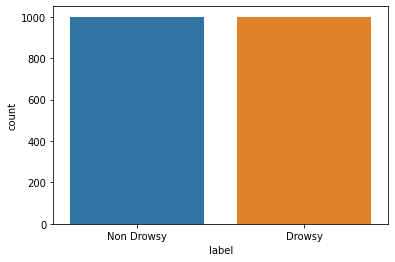

In [ ]:
sns.countplot(train['label'])

In [ ]:
image= train['image'][0]
img = load_img(image, grayscale=True)
img = np.array(img)
img.shape
# train['image'][0]

(227, 227)

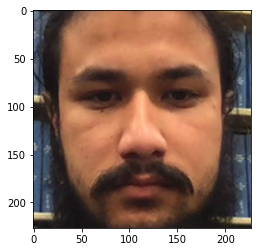

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

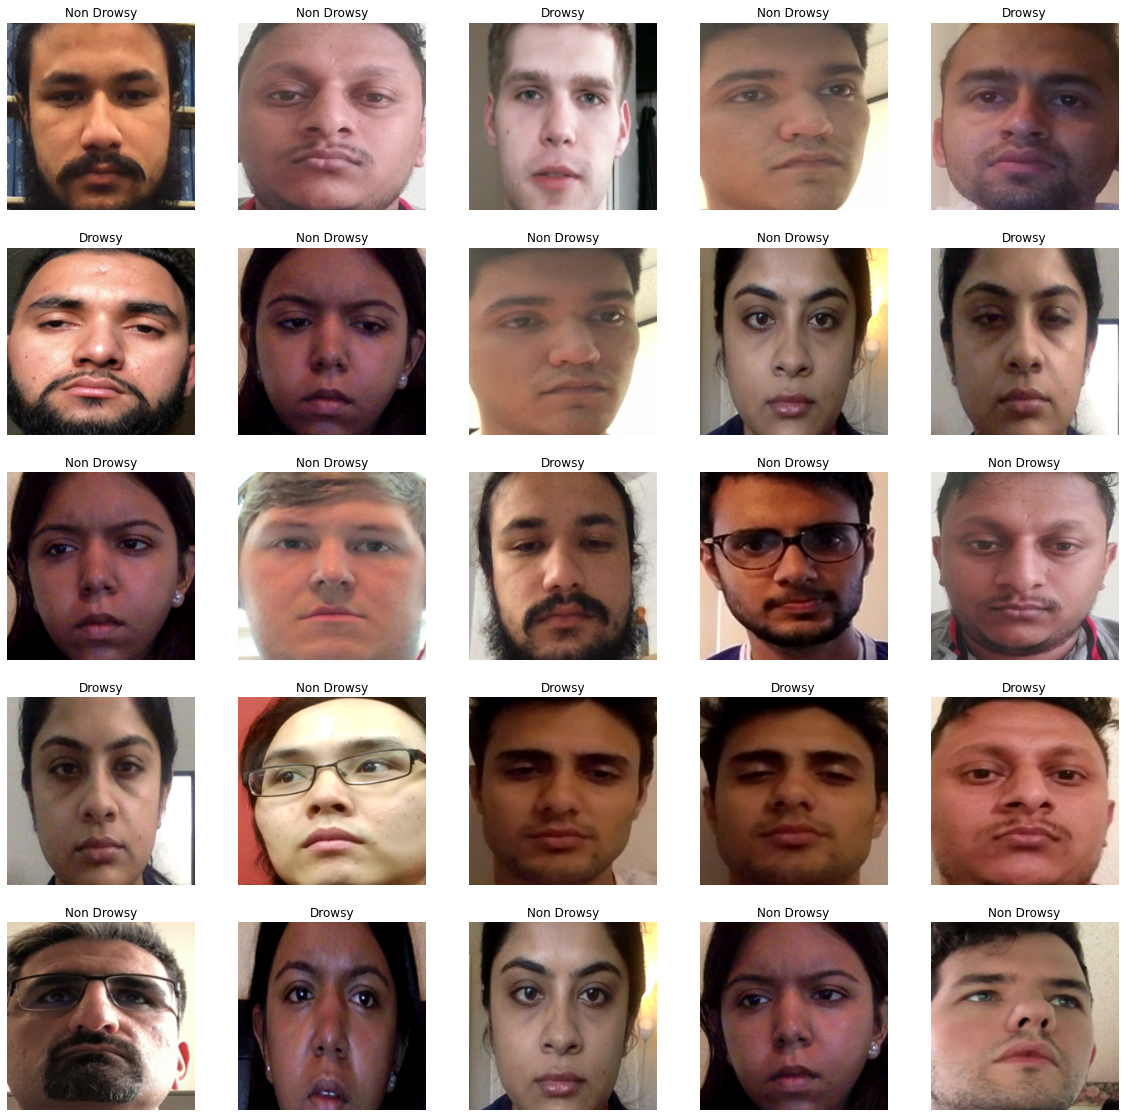

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 227, 227, 1)
    return features

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
val_features = extract_features(val['image'])

  0%|          | 0/800 [00:00<?, ?it/s]

In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0
x_val = val_features/255.0

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])
y_val = le.transform(val['label'])

In [ ]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

In [ ]:
y_train[0]

array([0., 1.], dtype=float32)

In [ ]:
# config
input_shape = (227, 227, 1)
output_class = 2

## Model Creation

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
16/16 [==============================] - 58s 2s/step - loss: 0.7513 - accuracy: 0.5290 - val_loss: 0.6895 - val_accuracy: 0.5362
Epoch 2/10
16/16 [==============================] - 25s 2s/step - loss: 0.6677 - accuracy: 0.5920 - val_loss: 0.6623 - val_accuracy: 0.6737
Epoch 3/10
16/16 [==============================] - 26s 2s/step - loss: 0.6133 - accuracy: 0.6935 - val_loss: 0.6845 - val_accuracy: 0.5475
Epoch 4/10
16/16 [==============================] - 26s 2s/step - loss: 0.5270 - accuracy: 0.7675 - val_loss: 0.4185 - val_accuracy: 0.8350
Epoch 5/10
16/16 [==============================] - 25s 2s/step - loss: 0.3777 - accuracy: 0.8485 - val_loss: 0.3264 - val_accuracy: 0.8687
Epoch 6/10
16/16 [==============================] - 25s 2s/step - loss: 0.1826 - accuracy: 0.9280 - val_loss: 0.1673 - val_accuracy: 0.9187
Epoch 7/10
16/16 [==============================] - 26s 2s/step - loss: 0.0984 - accuracy: 0.9675 - val_loss: 0.0699 - val_accuracy: 0.9825
Epoch 8/10
16/16 [==

## Plot the Results

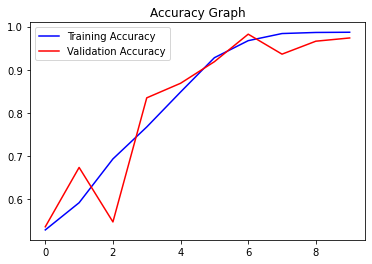

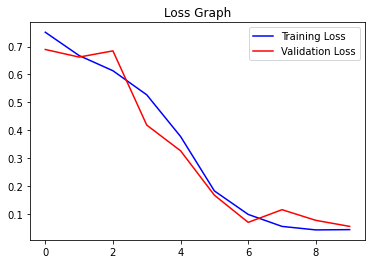

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output: Non Drowsy
Predicted Output: Non Drowsy


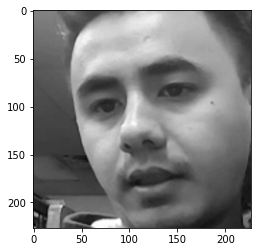

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 227, 227, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(227, 227), cmap='gray');

In [ ]:
test.iloc[0:25].itertuples()

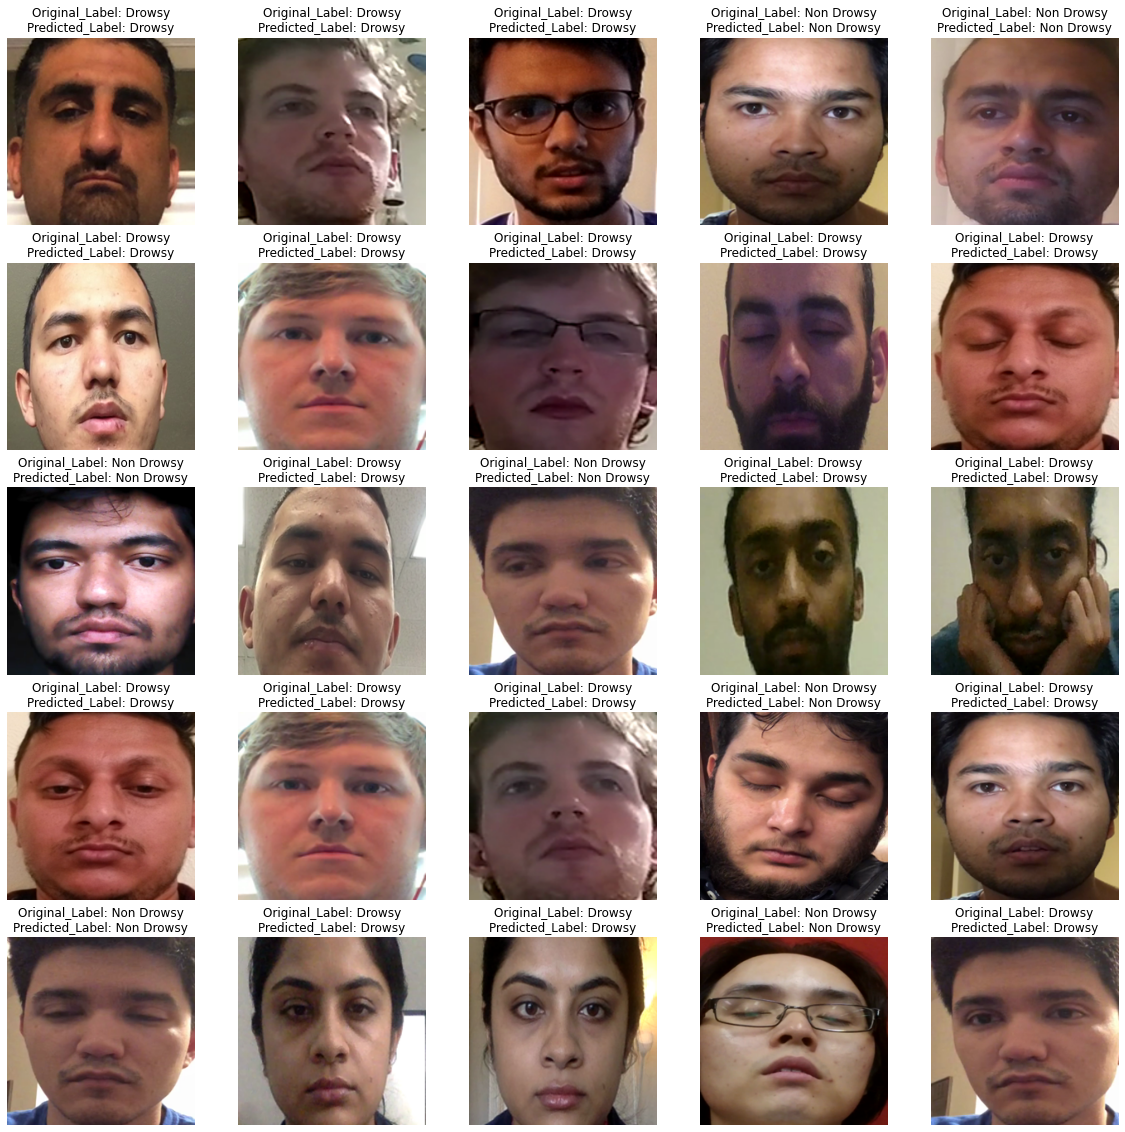

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
# files = test.iloc[0:25]
files = test.sample(25).reset_index(drop=True)


for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    image_index = random.randint(0, len(test))
    original_label = test['label'][image_index]
#     print("Original Output:", test['label'][image_index])
    pred = model.predict(x_test[image_index].reshape(1, 227, 227, 1))
    prediction_label = le.inverse_transform([pred.argmax()])[0]
#     print("Predicted Output:", prediction_label)
    plt.title(f"Original_Label: {original_label}\nPredicted_Label: {prediction_label}")
    plt.axis('off')
    plt.imshow(img)

Original Output: Non Drowsy
Predicted Output: Non Drowsy


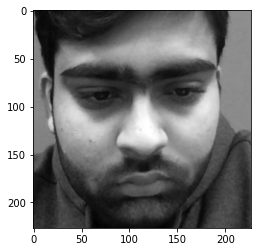

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 227, 227, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(227, 227), cmap='gray');

Original Output: Drowsy
Predicted Output: Drowsy


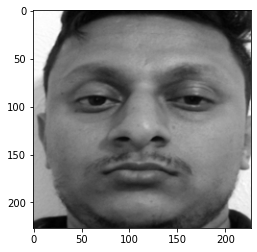

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 227, 227, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(227, 227), cmap='gray');

In [ ]:
model.save('drosy_v1.h5')
print('Model Saved!')

Model Saved!


In [ ]:
from PIL import Image
import requests
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQWlCSwkVplKaibBIwc4EBwYCg-nDOTbMyaK6C_7Oee4NUHzcEziXvsY2TSKBqXUnHVA1c&usqp=CAU"
im = Image.open(requests.get(url, stream=True).raw)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
img = cv2.imread(url)
img

In [ ]:
!cd /content/drive


In [ ]:
!ls

data   driver-drowsiness-dataset-ddd	  drosy_v1.h5  sample_data
drive  driver-drowsiness-dataset-ddd.zip  kaggle.json


In [ ]:
import shutil
shutil.copy('/content/drosy_v1.h5','/content/drive/MyDrive/Driver Drowsiness Project')

'/content/drive/MyDrive/Driver Drowsiness Project/drosy_v1.h5'